# **Library Book Recommendation System**
---
Authors: [Monicah Iwagit](https://github.com/Okodoimonicah), [Bradley Azegele](https://github.com/Azegele), [Emmanuel Kipkorir](), [Belinda Nyamai](), [Femi Kamau](https://github.com/ctrl-Karugu), and [Dennis Kimiri]()

## 1. Business Understanding

### 1.1 Problem Statement
>The tremendous growth and usage of information has led to information overloading where users find it difficult to locate the right information at a specified time. Although there are previous studies conducted on library recommender systems, the datasets used were small compared to the dataset we intend to use hence minimal area coverage. Recommending the right library books is a challenge due to the variety of genres available and the huge collection of books provided. A user finds it difficult to select the most appropriate book that will suit their academic needs, this process consumes a lot of time that the user would have used to sharpen on their desired skills. Additionally, many books in the library are rarely utilized which results in a waste of library resources. Having a personalized recommendation system seeks to predict the preference based on the user’s interest, behavior and information. The application of recommender systems in the university library solves the problem of difficulty in choosing books and improves utilization rate of library resources. 

## 2. Data Understanding
> The goal of the Data Understanding phase is to provide a solid foundation for the subsequent steps, including data preparation, exploratory data analysis, model development, and evaluation.

#### Load Libraries

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
import warnings

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

### 2.1 Collect Initial Data
> The goal of this section is to acquire the necessary data and load it into the notebook.

> The data used in this project was sourced from 2 different sources:
>   1. The first was source was from Cai-Nicolas Ziegler in a 4-week crawl (August-September [2004]) in the University of Freiburg, Germany. This can be found [here](http://www2.informatik.uni-freiburg.de/~cziegler/BX/). The data obtained are 3 datasets with information on [users](./data/BX-Users.csv), [ratings](./data/BX-Book-Ratings.csv) and [books](./data/BX-Books.csv) from a library.
>
>   2. The second set of data was sourced from the [Google Books API](https://developers.google.com/books). This data was obtained by using ISBNs in the books dataset from the first source. The script used to extract the data can be found [here](./make_dataset.py). This data was then stored in csv format and can be found [here](./data/books.csv).

#### Load Data

In [2]:
# (Source 1)
ratings = pd.read_csv("data/BX-Book-Ratings.csv", sep=";", error_bad_lines=False, encoding="latin-1")
books = pd.read_csv("data/BX-Books.csv", sep=";", error_bad_lines=False, encoding="latin-1")
users = pd.read_csv("data/BX-Users.csv", sep=";", error_bad_lines=False, encoding="latin-1")

# (Source 2)
books_extra = pd.read_csv("data/books.csv", encoding="latin-1")

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'


### 2.2 Describe Data
> The goal of this section is to examine the data and document its surface properties.

In [3]:
# Define class to describe the data 
class DescribeData():
    """This class is used to describe the data in a DataFrame."""
    
    def __init__(self, df) -> None:
        
        # Get the DataFrame
        self.df = df
        
        # Get the datatypes of the columns in the DataFrame
        self.datatypes = df.dtypes
         
        # Get the shape of the DataFrame
        self.shape = f"The shape of the DataFrame is {df.shape}\n\nRecords: {df.shape[0]}\nColumns: {df.shape[1]}"
        
        # Get the number of missing values in each column
        self.missing = f"There are a total of {df.isnull().sum().values.sum()} missing values in the DataFrame.\n\n{df.isnull().sum()}"
        
        # Get the number of duplicate rows
        self.duplicates = f"There are {df.duplicated().sum()} duplicated records in the DataFrame."

#### 2.2.1 `ratings`

In [4]:
# Create an instance of the 'DescribeData' class for the 'ratings' DataFrame
rt = DescribeData(ratings)

In [5]:
# Preview the 'ratings' DataFrame
rt.df.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [6]:
# Inspect the information about the DataFrame
rt.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [7]:
# Inspect the shape of the DataFrame
print(rt.shape)

The shape of the DataFrame is (1149780, 3)

Records: 1149780
Columns: 3


In [8]:
# Inspect the datatypes of the columns in the DataFrame
print(rt.datatypes)

User-ID         int64
ISBN           object
Book-Rating     int64
dtype: object


In [9]:
# Inspect the summary statistics of the DataFrame
rt.df.describe()

,User-ID,Book-Rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


In [10]:
# Inspect the number of missing values in each column
print(rt.missing)

There are a total of 0 missing values in the DataFrame.

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64


In [11]:
# Inspect the duplicates in the DataFrame
print(rt.duplicates)

There are 0 duplicated records in the DataFrame.


[**Ratings Dataset**](./data/BX-Book-Ratings.csv)

>* Spans **3** columns and **1,149,780** rows.

>* Contains **2** unique datatypes: 
>    * **int64**
>    * **object**

>* Has no missing values

>* Has no duplicates

#### 2.2.2 `books` 

In [12]:
# Instantiate the 'DescribeData' class for the 'books' DataFrame
bk = DescribeData(books)

In [13]:
# Preview the 'books' DataFrame
bk.df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg


In [14]:
# Inspect the information about the DataFrame
bk.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [15]:
# Inspect the shape of the DataFrame
print(bk.shape)

The shape of the DataFrame is (271360, 8)

Records: 271360
Columns: 8


In [16]:
# Inspect the datatypes of the columns in the DataFrame
print(bk.datatypes)

ISBN                   object
Book-Title             object
Book-Author            object
Year-Of-Publication    object
Publisher              object
Image-URL-S            object
Image-URL-M            object
Image-URL-L            object
dtype: object


In [17]:
# Inspect the missing values in the DataFrame
print(bk.missing)

There are a total of 6 missing values in the DataFrame.

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64


In [18]:
# Inspect the duplicates in the DataFrame
print(bk.duplicates)

There are 0 duplicated records in the DataFrame.


[**Books Dataset**](./data/BX-Books.csv)

>* Spans **8** columns and **271,359** rows.

>* Contains 1 unique datatype: 
>   * **object**

>* Has **6** missing values:
>   * Book-Author: **1** 
>   * Publisher: **2**
>   * Image-URL-L: **3**

>* Has no duplicates

#### 2.2.3 `users` 

In [19]:
# Instantiate the 'DescribeData' class for the 'users' DataFrame
ur = DescribeData(users)

In [20]:
# Preview the 'users' DataFrame
ur.df.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [21]:
# Inspect the information about the DataFrame
ur.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [22]:
# Inspect the shape of the DataFrame
print(ur.shape)

The shape of the DataFrame is (278858, 3)

Records: 278858
Columns: 3


In [23]:
# Inspect the datatypes of the columns in the DataFrame
print(ur.datatypes)

User-ID       int64
Location     object
Age         float64
dtype: object


In [24]:
# Inspect the summary statistics of the DataFrame
ur.df.describe()

,User-ID,Age
count,278858.00000,168096.000000
mean,139429.50000,34.751434
std,80499.51502,14.428097
min,1.00000,0.000000
25%,69715.25000,24.000000
50%,139429.50000,32.000000
75%,209143.75000,44.000000
max,278858.00000,244.000000


In [25]:
# Inspect the missing values in the DataFrame
print(ur.missing)

There are a total of 110762 missing values in the DataFrame.

User-ID          0
Location         0
Age         110762
dtype: int64


In [26]:
# Inspect the duplicates in the DataFrame
print(ur.duplicates)

There are 0 duplicated records in the DataFrame.


[**Users Dataset**](./data/BX-Users.csv)

>* Spans **3** columns and **278,857** rows.

>* Contains **3** unique datatypes:
>   * **int64**
>   * **float64**
>   * **object**

>* Has **110762** missing values:
>   * Age: **110,762**

>* Has no duplicates

#### 2.2.4 `books_extra`

In [27]:
# Instantiate the 'DescribeData' class for the 'books_extra' DataFrame
bk_extra = DescribeData(books_extra)

In [28]:
# Preview the 'books_extra' DataFrame
bk_extra.df.head()

,authors,published_date,description,isbn_10,isbn_13,page_count,categories,maturity_rating,language,join_isbn_10
0,"['Mark P. O. Morford', 'Robert J. Lenardon']",2003,"Provides an introduction to classical myths placing the addressed topics within their historical context, discussion of archaeological evidence as support for mythical events, and how these themes have been portrayed in literature, art, music, and film.",0195153448,9780195153446.0,808.0,['Social Science'],NOT_MATURE,en,0195153448
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0002005018
2,"[""Carlo D'Este""]",1991,"Here, for the first time in paperback, is an outstanding military history that offers a dramatic new perspective on the Allied campaign that began with the invasion of the D-Day beaches of Normandy. Nationa advertising in Military History.",IND:30000026059836,NaN,582.0,['1940-1949'],NOT_MATURE,en,0060973129
3,['Gina Bari Kolata'],1999,"Describes the great flu epidemic of 1918, an outbreak that killed some forty million people worldwide, and discusses the efforts of scientists and public health officials to understand and prevent another lethal pandemic",9780374157067,374157065.0,367.0,['Medical'],NOT_MATURE,en,0374157065
4,['E. J. W. Barber'],1999,"A look at the incredibly well-preserved ancient mummies found in Western China describes their clothing and appearance, attempts to reconstruct their culture, and speculates about how Caucasians could have found their way to the feet of the Himalayan mountains.",0393045218,9780393045215.0,240.0,['Design'],NOT_MATURE,en,0393045218


In [29]:
# Inspect the information about the DataFrame
bk_extra.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266401 entries, 0 to 266400
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   authors          200900 non-null  object 
 1   published_date   202728 non-null  object 
 2   description      171784 non-null  object 
 3   isbn_10          202788 non-null  object 
 4   isbn_13          171364 non-null  object 
 5   page_count       201597 non-null  float64
 6   categories       189620 non-null  object 
 7   maturity_rating  202848 non-null  object 
 8   language         202848 non-null  object 
 9   join_isbn_10     266400 non-null  object 
dtypes: float64(1), object(9)
memory usage: 20.3+ MB


In [30]:
# Inspect the shape of the DataFrame
print(bk_extra.shape)

The shape of the DataFrame is (266401, 10)

Records: 266401
Columns: 10


In [31]:
# Inspect the datatypes of the columns in the DataFrame
print(bk_extra.datatypes)

authors             object
published_date      object
description         object
isbn_10             object
isbn_13             object
page_count         float64
categories          object
maturity_rating     object
language            object
join_isbn_10        object
dtype: object


In [32]:
# Inspect the summary statistics of the DataFrame
bk_extra.df.describe()

,page_count
count,201597.000000
mean,279.266581
std,179.229782
min,0.000000
25%,176.000000
50%,260.000000
75%,356.000000
max,3596.000000


In [33]:
# Inspect the missing values in the DataFrame
print(bk_extra.missing)

There are a total of 651133 missing values in the DataFrame.

authors            65501
published_date     63673
description        94617
isbn_10            63613
isbn_13            95037
page_count         64804
categories         76781
maturity_rating    63553
language           63553
join_isbn_10           1
dtype: int64


In [34]:
# Inspect the duplicates in the DataFrame
print(bk_extra.duplicates)

There are 0 duplicated records in the DataFrame.


[**Books (Extra) Dataset**](./data/books.csv)

>* Spans **10** columns and **()** rows.

>* Contains **2** unique datatypes:
>   * **float64**
>   * **object**

>* Has **()** missing values:

>* Has no duplicates

## 3. Data Preparation
> The goal of the Data Preparation phase, which is often referred to as “data munging”, prepares the final data set(s) for modeling.

### Users Dataset

#### Cleaning data

In [35]:
#splitting a string into a list
list_ = users.Location.str.split(', ')

#empty lists to add values  
city = []
state = []
country = []
count_no_state = 0    
count_no_country = 0
#generating a for loop to add values to the empty lists
for i in range(0,len(list_)):
    #removing invalid entries in city
    if list_[i][0] == ' ' or list_[i][0] == '' or list_[i][0]=='n/a' or list_[i][0] == ',':  
        city.append('other')
    else:
        city.append(list_[i][0].lower())

    if(len(list_[i])<2):
        state.append('other')
        country.append('other')
        count_no_state += 1
        count_no_country += 1
    else:
        #removing invalid entries in state
        if list_[i][1] == ' ' or list_[i][1] == '' or list_[i][1]=='n/a' or list_[i][1] == ',':   
            state.append('other')
            count_no_state += 1            
        else:
            state.append(list_[i][1].lower())
        
        if(len(list_[i])<3):
            country.append('other')
            count_no_country += 1
        else:
            #removing invalid entries in country
            if list_[i][2] == ''or list_[i][1] == ',' or list_[i][2] == ' ' or list_[i][2] == 'n/a':
                country.append('other')
                count_no_country += 1
            else:
                country.append(list_[i][2].lower())
        
#dropping the location column from users             
users = users.drop('Location',axis=1)

#handling cases where city/state from the lists is already given
temp = []
for ent in city:
    c = ent.split('/')            
    temp.append(c[0])
    
#creating a dataframe for city, state and country
df_city = pd.DataFrame(temp,columns=['City'])
df_state = pd.DataFrame(state,columns=['State'])
df_country = pd.DataFrame(country,columns=['Country'])

#adding the new dataframes to the original users dataframe 
users = pd.concat([users, df_city], axis=1)
users = pd.concat([users, df_state], axis=1)
users = pd.concat([users, df_country], axis=1)

#printing the number of countries that do not have values 
print(count_no_country)

#printing the states which didnt have any values
print(count_no_state)     

4659
16044


In [36]:
## Drop duplicate rows
users.drop_duplicates(keep='last', inplace=True)
users.reset_index(drop=True, inplace=True)

In [37]:
#confirming that the new dataframes have been added to users
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   User-ID  278858 non-null  int64  
 1   Age      168096 non-null  float64
 2   City     278858 non-null  object 
 3   State    278858 non-null  object 
 4   Country  278858 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 10.6+ MB


In [38]:
users.head()

,User-ID,Age,City,State,Country
0,1,NaN,nyc,new york,usa
1,2,18.0,stockton,california,usa
2,3,NaN,moscow,yukon territory,russia
3,4,17.0,porto,v.n.gaia,portugal
4,5,NaN,farnborough,hants,united kingdom


#### Dealing with missing values in the Age column

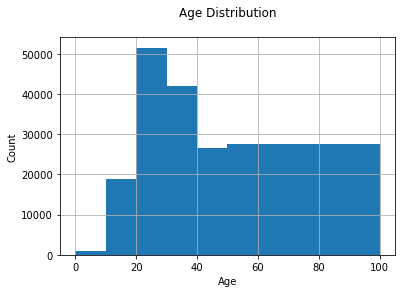

In [39]:
#checking the Age distribution
users.Age.hist(bins=[0, 10, 20, 30, 40, 50, 100])
plt.title('Age Distribution\n')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

The most active users are in the age bracket between 20 to 30 years.

Text(0.5, 1.0, 'Outliers present in the Age column')

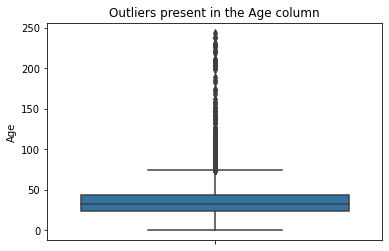

In [40]:
#checking for outliers in the age column using a boxplot
sns.boxplot(y='Age', data=users)
plt.title('Outliers present in the Age column')

The boxplot shows that age has positive skewness(Right Tail) hence median can be used to fill null values

In [41]:
#checking all values present in the Age column
print(sorted(list(users['Age'].unique())))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

Text(0.5, 1.0, 'Age Distribution Plot')

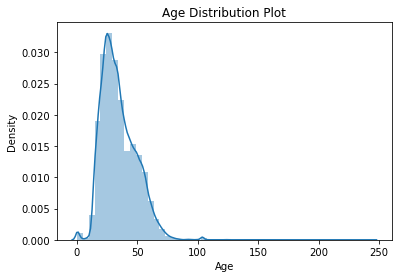

In [42]:
#plotting a distribution plot to discover the relevant age bracket 
sns.distplot(users.Age)
plt.title('Age Distribution Plot')

Evidently, ages below 10 and above 80 do not make sense for book rating

In [43]:
# grouping ages below 10 and above 80
required = users[users['Age'] <= 80]
required = required[required['Age'] >= 10]
#calculating the median for the required ages
median = round(required['Age'].median())   
median

32.0

In [44]:
#outliers with age greater than 80 years are substituted with median 
users.loc[users['Age'] > 80, 'Age'] = median

#outliers with age less than 10 years are substitued with median
users.loc[users['Age'] < 10, 'Age'] = median 

#filling null values with median
users['Age'] = users['Age'].fillna(median)

#changing the datatype to an integer
users['Age'] = users['Age'].astype(int)      

In [45]:
#confirming that the missing values have been dealt with
users.isna().sum()

User-ID    0
Age        0
City       0
State      0
Country    0
dtype: int64

### Books Dataset

In [46]:
#merge books dataset to books_extra
upgrade = books.merge(books_extra, right_on = 'join_isbn_10', left_on = 'ISBN', how = 'inner')

In [47]:
up_grad = DescribeData(upgrade)

In [48]:
up_grad.df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,authors,published_date,description,isbn_10,isbn_13,page_count,categories,maturity_rating,language,join_isbn_10
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg,"['Mark P. O. Morford', 'Robert J. Lenardon']",2003,"Provides an introduction to classical myths placing the addressed topics within their historical context, discussion of archaeological evidence as support for mythical events, and how these themes have been portrayed in literature, art, music, and film.",0195153448,9780195153446.0,808.0,['Social Science'],NOT_MATURE,en,0195153448
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0002005018
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg,"[""Carlo D'Este""]",1991,"Here, for the first time in paperback, is an outstanding military history that offers a dramatic new perspective on the Allied campaign that began with the invasion of the D-Day beaches of Normandy. Nationa advertising in Military History.",IND:30000026059836,NaN,582.0,['1940-1949'],NOT_MATURE,en,0060973129
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg,['Gina Bari Kolata'],1999,"Describes the great flu epidemic of 1918, an outbreak that killed some forty million people worldwide, and discusses the efforts of scientists and public health officials to understand and prevent another lethal pandemic",9780374157067,374157065.0,367.0,['Medical'],NOT_MATURE,en,0374157065
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg,['E. J. W. Barber'],1999,"A look at the incredibly well-preserved ancient mummies found in Western China describes their clothing and appearance, attempts to reconstruct their culture, and speculates about how Caucasians could have found their way to the feet of the Himalayan mountains.",0393045218,9780393045215.0,240.0,['Design'],NOT_MATURE,en,0393045218


In [49]:
up_grad.df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 259172 entries, 0 to 259171
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ISBN                 259172 non-null  object 
 1   Book-Title           259172 non-null  object 
 2   Book-Author          259171 non-null  object 
 3   Year-Of-Publication  259172 non-null  object 
 4   Publisher            259170 non-null  object 
 5   Image-URL-S          259172 non-null  object 
 6   Image-URL-M          259172 non-null  object 
 7   Image-URL-L          259169 non-null  object 
 8   authors              200899 non-null  object 
 9   published_date       202727 non-null  object 
 10  description          171783 non-null  object 
 11  isbn_10              202788 non-null  object 
 12  isbn_13              171364 non-null  object 
 13  page_count           201597 non-null  float64
 14  categories           189620 non-null  object 
 15  maturity_rating  

In [50]:
print(up_grad.missing)

There are a total of 586080 missing values in the DataFrame.

ISBN                       0
Book-Title                 0
Book-Author                1
Year-Of-Publication        0
Publisher                  2
Image-URL-S                0
Image-URL-M                0
Image-URL-L                3
authors                58273
published_date         56445
description            87389
isbn_10                56384
isbn_13                87808
page_count             57575
categories             69552
maturity_rating        56324
language               56324
join_isbn_10               0
dtype: int64


In [51]:
# define class for data cleaning
class DataCleaning:
    def __init__(self, data):
        self.data = data
        
    def drop_null_rows(self):
        """Drops rows with null values."""
        self.data = self.data.dropna()
        return self.data

    def drop_duplicate_rows(self):
        """Drops duplicate rows."""
        self.data = self.data.drop_duplicates()
        return self.data

    def handle_missing_values(self, column, method, value=None):
        """Handles missing values in a specified column.
        
        The method parameter take one of the following:
        "drop": Drops rows with missing values in the specified column.
        "fill": Fills missing values with the specified value.
        "interpolate": Interpolates missing values using linear interpolation.
        """
        if method == "drop":
            self.data = self.data.dropna(subset=[column])
        elif method == "fill":
            self.data[column] = self.data[column].fillna(value)
        elif method == "interpolate":
            self.data[column] = self.data[column].interpolate()
        else:
            raise ValueError("Invalid value for method parameter. Valid values are 'drop', 'fill', and 'interpolate'.")
        return self.data

    def convert_column_data_type(self, column, data_type):
        """Converts the data type of a specified column."""
        self.data[column] = self.data[column].astype(data_type)
        return self.data

In [52]:
data_cleaning = DataCleaning(upgrade)

In [53]:
#dropping rows with null values in the description column
upgrade = data_cleaning.handle_missing_values(column="description", method="drop")
upgrade.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,authors,published_date,description,isbn_10,isbn_13,page_count,categories,maturity_rating,language,join_isbn_10
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg,"['Mark P. O. Morford', 'Robert J. Lenardon']",2003,"Provides an introduction to classical myths placing the addressed topics within their historical context, discussion of archaeological evidence as support for mythical events, and how these themes have been portrayed in literature, art, music, and film.",0195153448,9780195153446.0,808.0,['Social Science'],NOT_MATURE,en,0195153448
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg,"[""Carlo D'Este""]",1991,"Here, for the first time in paperback, is an outstanding military history that offers a dramatic new perspective on the Allied campaign that began with the invasion of the D-Day beaches of Normandy. Nationa advertising in Military History.",IND:30000026059836,NaN,582.0,['1940-1949'],NOT_MATURE,en,0060973129
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg,['Gina Bari Kolata'],1999,"Describes the great flu epidemic of 1918, an outbreak that killed some forty million people worldwide, and discusses the efforts of scientists and public health officials to understand and prevent another lethal pandemic",9780374157067,374157065.0,367.0,['Medical'],NOT_MATURE,en,0374157065
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg,['E. J. W. Barber'],1999,"A look at the incredibly well-preserved ancient mummies found in Western China describes their clothing and appearance, attempts to reconstruct their culture, and speculates about how Caucasians could have found their way to the feet of the Himalayan mountains.",0393045218,9780393045215.0,240.0,['Design'],NOT_MATURE,en,0393045218
5,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0399135782.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0399135782.01.LZZZZZZZ.jpg,['Amy Tan'],1991,"A Chinese immigrant who is convinced she is dying threatens to celebrate the Chinese New Year by unburdening herself of everybody's hidden truths, thus prompting a series of comic misunderstandings",0399135782,9780399135781.0,428.0,['Fiction'],NOT_MATURE,en,0399135782


In [54]:
#dropping unwanted columns from the merged dataset
published = upgrade.drop(['Image-URL-S', 'Image-URL-M','Image-URL-L','authors','isbn_10', 'isbn_13'], axis=1)
published

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,published_date,description,page_count,categories,maturity_rating,language,join_isbn_10
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,2003,"Provides an introduction to classical myths placing the addressed topics within their historical context, discussion of archaeological evidence as support for mythical events, and how these themes have been portrayed in literature, art, music, and film.",808.0,['Social Science'],NOT_MATURE,en,0195153448
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,1991,"Here, for the first time in paperback, is an outstanding military history that offers a dramatic new perspective on the Allied campaign that began with the invasion of the D-Day beaches of Normandy. Nationa advertising in Military History.",582.0,['1940-1949'],NOT_MATURE,en,0060973129
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,1999,"Describes the great flu epidemic of 1918, an outbreak that killed some forty million people worldwide, and discusses the efforts of scientists and public health officials to understand and prevent another lethal pandemic",367.0,['Medical'],NOT_MATURE,en,0374157065
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,1999,"A look at the incredibly well-preserved ancient mummies found in Western China describes their clothing and appearance, attempts to reconstruct their culture, and speculates about how Caucasians could have found their way to the feet of the Himalayan mountains.",240.0,['Design'],NOT_MATURE,en,0393045218
5,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,1991,"A Chinese immigrant who is convinced she is dying threatens to celebrate the Chinese New Year by unburdening herself of everybody's hidden truths, thus prompting a series of comic misunderstandings",428.0,['Fiction'],NOT_MATURE,en,0399135782
...,...,...,...,...,...,...,...,...,...,...,...,...
259166,0449906736,Flashpoints: Promise and Peril in a New World,Robin Wright,1993,Ballantine Books,1992-12-22,"From two of America's most accomplished journalists comes a bold, provocative vision of a new world of violent upheavals and great opportunity. Drawing on their reporting experience from more than 70 countries and 14 wars, Wright and McManus investigate the radical changes engulfing the globe--and what they mean for the future.",276.0,['Political Science'],NOT_MATURE,en,0449906736
259167,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),1988,"On her own for the first time, fourteen-year-old Marcy tries to cope with the new people and situations she encounters while working as a counselor at an arts camp.",16.0,['Adolescence'],NOT_MATURE,en,0440400988
259169,006008667X,Lily Dale : The True Story of the Town that Talks to the Dead,Christine Wicker,2004,HarperSanFrancisco,2004-04,An award-winning and wry journalist captures the life and spirit of a 122-year-old town populated exclusively by people who believe the dead live among them.,300.0,['History'],NOT_MATURE,en,006008667X
259170,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,1993,"The central work of one of the West's greatest philosophers, The Republic of Plato is a masterpiece of insight and feeling, the finest of the Socratic dialogues, and one of the great books of Western culture. Now Robin Waterfield offers a new translation of The Republic, one that captures the dramatic realism, poetic beauty, intellectual vitality, and emotional power of Plato at his height. Deftly weaving three main strands of argument into an artistic whole--the ethical and political, the aesthetic and mystical, and the metaphysical--Plato explores in The Republic the elements of the ideal community, where morality can be achieved in a balance of wisdom, courage, and restraint. 

In [55]:
#checking for missing values after dropping unwanted columns
published.isna().sum()

ISBN                      0
Book-Title                0
Book-Author               0
Year-Of-Publication       0
Publisher                 1
published_date           19
description               0
page_count              490
categories             3842
maturity_rating           0
language                  0
join_isbn_10              0
dtype: int64

In [56]:
#checking the years of publication
published['Year-Of-Publication']=published['Year-Of-Publication'].astype('str')
a=list(published['Year-Of-Publication'].unique())
a=set(a)
a=list(a)
a = [x for x in a if x is not None]
a.sort()
print(a)

['0', '1378', '1901', '1902', '1909', '1910', '1911', '1914', '1920', '1921', '1923', '1924', '1925', '1927', '1929', '1930', '1931', '1932', '1933', '1935', '1936', '1937', '1938', '1939', '1940', '1941', '1942', '1943', '1944', '1945', '1946', '1947', '1948', '1949', '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2008', '2010', '2011', '2030', '2038', 'DK Publishing Inc', 'Gallimard']


In [57]:
published.loc[published['Year-Of-Publication'] == '0',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,published_date,description,page_count,categories,maturity_rating,language,join_isbn_10
502,8845229041,Biblioteca Universale Rizzoli: Sulla Sponda Del Fiume Piedra,P Coelho,0,Fabbri - RCS Libri,1996,"Pilar ritrova a Madrid l'amico dell'infanzia. Questi ha girato il mondo ed ÃÂ¨ poi entrato in seminario, dove si dice abbia fatto miracoli. Pilar ÃÂ¨ una donna passionale, ma delusa dalla vita. Con l'amico d'infanzia compie un viaggio di sei giorni durante il quale la donna ritrova se stessa attraverso una riflessione mistico-iniziatica. I due si recano a Lourdes dove cementeranno il loro amore alla luce di una fede che esalta i valori della missione nel mondo.",216.0,['Fiction'],NOT_MATURE,it,8845229041
606,0590021117,Little House On the Prairie,Laura Ingall Wilder,0,Scholastic Inc,1953,"A family travels from the big woods of Wisconsin, to a new home on the praire, where they build a house, meet neighboring Indians, build a well, and fight a praire fire.",221.0,['Families'],NOT_MATURE,en,0590021117
688,2070362388,Ravage,Rene Barjavel,0,Gallimard French,1972,"De l'autre cÃÂ´tÃÂ© de la Seine une coulÃÂ©e de quintessence enflammÃÂ©e atteint, dans les sous-sols de la caserne de Chaillot, ancien TrocadÃÂ©ro, le dÃÂ©pÃÂ´t de munitions et le laboratoire de recherches des poudres. Une formidable explosion entrouvre la colline. Des pans de murs, des colonnes, des rochers, des tonnes de dÃÂ©bris montent au-dessus du fleuve, retombent sur la foule agenouillÃÂ©e qui rÃÂ¢le son adoration et sa peur fendent les crÃÂ¢nes, arrachent les membres, brisent les os. Un ÃÂ©norme bloc de terre et de ciment aplatit d'un seul coup la moitiÃÂ© des fidÃÂ¨les de la paroisse du Gros-Caillou. En haut de la Tour, un jet de flammes arrache l'ostensoir des mains du prÃÂªtre ÃÂ©pouvantÃÂ©.",313.0,['Fiction'],NOT_MATURE,fr,2070362388
692,2266033689,Le Diable Au Corps,Raymond Radiguet,0,Presses Pocket French,1990,"Pendant la premiÃÂ¨re guerre mondiale, FranÃÂ§ois, un lycÃÂ©en, fait la connaissance de Marthe, une jeune femme de dix-huit ans. Celle-ci est fiancÃÂ©e ÃÂ Jacques, un soldat qui se bat sur le front. Au mÃÂ©pris des commÃÂ©rages, FranÃÂ§ois et Marthe vont devenir amants. Mais FranÃÂ§ois n'est-il pas trop jeune pour s'engager dans une telle liaison ?",206.0,NaN,NOT_MATURE,fr,2266033689
757,0718144538,Shattered Uk,Dick Francis,0,Michael Joseph Ltd,2000,"Gerard Logan finds that when his jockey friend dies following a fall at the Cheltenham races, he is involved in a desperate search for a stolen video tape which embroils him in more life-threatening hazards than does his work as a widely-acclaimed glass-blower.",271.0,['Detective and mystery stories'],NOT_MATURE,en,0718144538
...,...,...,...,...,...,...,...,...,...,...,...,...
256752,2253034304,Les Allumettes Suedoises,Robert Sabatier,0,Livre De Poche French,1996,"Sur les pentes de Montmartre, un enfant de dix ans, Olivier, erre le jour et aussi la nuit dans ce vieux quartier de paris du dÃ©but des annÃ©es 30. Sa mÃ¨re, la belle merciÃ¨re, vient de mourir et il vit en partie chez le jeune couple formÃ© par ses cousins Jean et Elodie, mais surtout dans les rues de ce temps-lÃ , vivantes, souriantes, animÃ©es. C'est lÃ qu'il rencontre une multitude de personnages populaires qui vivent et se croisent sous son regard vif, Ã©merveillÃ©, parfois mÃ©lancolique. Soumis Ã toutes sortes d'influences, cet enfant sera peu Ã peu la fÃ©erie des rues effacer sa peine et sa solitude. C'est une ville inattendue qui apparaÃ®t alors, un Paris diffÃ©rent de celui que nous connaissons, des coutumes changÃ©es, une autre maniÃ¨re de vivre. Merveilleux roman plein de fraÃ®cheur et de charme, de tendresse et d'humour, les Allumettes suÃ©doises est un des plus grands succÃ¨s de ces derniÃ¨res annÃ©es.",244.0,['Fiction'],NOT_MATURE,fr,2253034304
258296,0571204163,Headlong,Michael Frayn,0,Faber Faber Inc,1999,"An unlikely con man wagers wife, wealth, a

In [58]:
def replace_year_of_publication(published):
    #Replace values where the "Year-Of-Publication" is 0 with the corresponding value in the "published-data" column
    published["Year-Of-Publication"] = published["Year-Of-Publication"].mask(published["Year-Of-Publication"] == '0', published["published_date"])

#Replace the values where the "Year-Of-Publication" is 0
replace_year_of_publication(published)

In [59]:
#confirming the years with 0 have been replaced 
published.loc[published['Year-Of-Publication'] == '0',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,published_date,description,page_count,categories,maturity_rating,language,join_isbn_10


In [60]:
#investigating the rows having 'DK Publishing Inc' as yearOfPublication
published.loc[published['Year-Of-Publication'] == 'DK Publishing Inc',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,published_date,description,page_count,categories,maturity_rating,language,join_isbn_10
198735,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\"";Michael Teitelbaum""",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg,2000,"Provides information on such original characters from the X-men comic strip as Professor X, Iceman, Angel, Magneto, and Beast.",48.0,['Juvenile Fiction'],NOT_MATURE,en,078946697X
210728,0789466953,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\"";James Buckley""",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg,2000,"Meet the artists, writers and others who make X - Men comic books come to life! Includes exclusive X - Men art! Stunning photographs combine with lively illustrations and engaging, age - appropriate stories in DK Readers, a multilevel reading program guaranteed to capture children's interest while developing their reading skills and general knowledge.",54.0,['Graphic novels'],NOT_MATURE,en,0789466953


It can be observed that there are some incorrect entries in Year-Of-Publication field since publisher names 'DK Publishing Inc' has been incorrectly loaded as Year-Of-Publication in dataset due to some errors in csv file. 

In [61]:
#Since bookAuthor is incorrectly loaded with publication year; making required corrections
#ISBN '0789466953'
published.loc[published.ISBN == '0789466953','Year-Of-Publication'] = 2000
published.loc[published.ISBN == '0789466953','Book-Author'] = "James Buckley"
published.loc[published.ISBN == '0789466953','Publisher'] = "DK Publishing Inc"
published.loc[published.ISBN == '0789466953','Book-Title'] = "DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)"

#ISBN '078946697X'
published.loc[published.ISBN == '078946697X','Year-Of-Publication'] = 2000
published.loc[published.ISBN == '078946697X','Book-Author'] = "Michael Teitelbaum"
published.loc[published.ISBN == '078946697X','Publisher'] = "DK Publishing Inc"
published.loc[published.ISBN == '078946697X','Book-Title'] = "DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)"

#rechecking that the errors have been corrected
published.loc[(published.ISBN == '0789466953') | (published.ISBN == '078946697X'),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,published_date,description,page_count,categories,maturity_rating,language,join_isbn_10
198735,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)",Michael Teitelbaum,2000,DK Publishing Inc,2000,"Provides information on such original characters from the X-men comic strip as Professor X, Iceman, Angel, Magneto, and Beast.",48.0,['Juvenile Fiction'],NOT_MATURE,en,078946697X
210728,0789466953,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)",James Buckley,2000,DK Publishing Inc,2000,"Meet the artists, writers and others who make X - Men comic books come to life! Includes exclusive X - Men art! Stunning photographs combine with lively illustrations and engaging, age - appropriate stories in DK Readers, a multilevel reading program guaranteed to capture children's interest while developing their reading skills and general knowledge.",54.0,['Graphic novels'],NOT_MATURE,en,0789466953


In [62]:
#investigating the rows having 'Gallimard' as yearOfPublication
published.loc[published['Year-Of-Publication'] == 'Gallimard',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,published_date,description,page_count,categories,maturity_rating,language,join_isbn_10
209793,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-Marie Gustave Le ClÃ?Â©zio""",2003,Gallimard,http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg,2002,"Deux enfants vivent une expÃ©rience qui bouleverse leur vie : Petite Croix, jeune aveugle en quÃªte de la couleur bleue, dÃ©couvre la beautÃ© du monde au cours d'un Ã©tonnant voyage intÃ©rieur, tandis que Gaspar, Ã©levÃ© dans une ville, se voit rÃ©vÃ©ler la libertÃ© du nomadisme... Des histoires insolites oÃ¹ les enfants sont des magiciens qui nous entraÃ®nent de l'autre cÃ´tÃ© du miroir. RÃ©cits initiatiques, passages d'un monde Ã un autre, ces nouvelles poÃ©tiques semblent nÃ©es du rÃªve d'un Ã©crivain.",132.0,['Fiction'],NOT_MATURE,fr,2070426769


In [63]:
#making required corrections for Gallimard while keeping other fields intact
published.loc[published.ISBN == '2070426769','Year-Of-Publication'] = 2003
published.loc[published.ISBN == '2070426769','Book-Author'] = "Jean-Marie Gustave Le ClÃ?Â©zio"
published.loc[published.ISBN == '2070426769','Publisher'] = "Gallimard"
published.loc[published.ISBN == '2070426769','Book-Title'] = "Peuple du ciel, suivi de 'Les Bergers"

#rechecking that the corrections have been made
published.loc[published.ISBN == '2070426769',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,published_date,description,page_count,categories,maturity_rating,language,join_isbn_10
209793,2070426769,"Peuple du ciel, suivi de 'Les Bergers",Jean-Marie Gustave Le ClÃ?Â©zio,2003,Gallimard,2002,"Deux enfants vivent une expÃ©rience qui bouleverse leur vie : Petite Croix, jeune aveugle en quÃªte de la couleur bleue, dÃ©couvre la beautÃ© du monde au cours d'un Ã©tonnant voyage intÃ©rieur, tandis que Gaspar, Ã©levÃ© dans une ville, se voit rÃ©vÃ©ler la libertÃ© du nomadisme... Des histoires insolites oÃ¹ les enfants sont des magiciens qui nous entraÃ®nent de l'autre cÃ´tÃ© du miroir. RÃ©cits initiatiques, passages d'un monde Ã un autre, ces nouvelles poÃ©tiques semblent nÃ©es du rÃªve d'un Ã©crivain.",132.0,['Fiction'],NOT_MATURE,fr,2070426769


In [64]:
#investigating the rows having 'nan' as yearOfPublication
published.loc[published['Year-Of-Publication'] == 'nan',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,published_date,description,page_count,categories,maturity_rating,language,join_isbn_10


In [65]:
#converting year of publication to integers
published['Year-Of-Publication']=pd.to_numeric((published['Year-Of-Publication']), errors='coerce')

print(sorted(published['Year-Of-Publication'].unique()))

[1913.0, 1920.0, 1941.0, 1950.0, 1951.0, 1953.0, 1954.0, 1958.0, 1959.0, 1960.0, 1961.0, 1962.0, 1964.0, 1965.0, 1968.0, 1969.0, 1970.0, 1971.0, 1972.0, 1973.0, 1974.0, 1975.0, 1976.0, 1977.0, 1978.0, 1979.0, 1980.0, 1981.0, 1982.0, 1983.0, 1984.0, 1985.0, 1986.0, 1987.0, 1988.0, 1989.0, 1990.0, 1991.0, 1992.0, 1993.0, 1994.0, 1995.0, 1996.0, 1997.0, 1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, nan, 1378.0, 1859.0, 1887.0, 1901.0, 1902.0, 1908.0, 1909.0, 1910.0, 1911.0, 1914.0, 1921.0, 1922.0, 1923.0, 1924.0, 1925.0, 1927.0, 1929.0, 1930.0, 1931.0, 1932.0, 1933.0, 1934.0, 1935.0, 1936.0, 1937.0, 1938.0, 1939.0, 1940.0, 1942.0, 1943.0, 1944.0, 1945.0, 1946.0, 1947.0, 1948.0, 1949.0, 1952.0, 1955.0, 1956.0, 1957.0, 1963.0, 1966.0, 1967.0, 2005.0, 2006.0, 2007.0, 2008.0, 2010.0, 2011.0, 2030.0, 2038.0]


In [66]:
#replacing years above 2004 and those with no value with the median
published.loc[(published['Year-Of-Publication'] > 2004) | (published['Year-Of-Publication'] == 0),'Year-Of-Publication'] = np.NAN

#replacing NaNs with median value of Year-Of-Publication
published['Year-Of-Publication'].fillna(round(published['Year-Of-Publication'].median()), inplace=True)

In [67]:
#dropping the published date column since it will not be required for analysis
published2 = published.drop(['published_date'], axis=1)

In [68]:
published2.isna().sum()

ISBN                      0
Book-Title                0
Book-Author               0
Year-Of-Publication       0
Publisher                 1
description               0
page_count              490
categories             3842
maturity_rating           0
language                  0
join_isbn_10              0
dtype: int64

In [69]:
#exploring 'publisher' column
published2.loc[published2.Publisher.isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,description,page_count,categories,maturity_rating,language,join_isbn_10
120762,1931696993,Finders Keepers,Linnea Sinclair,2001.0,NaN,"Be careful what you wish for. You might get it... Her ship's in shambles, her boyfriend's dumped her and she's frankly out of funds. Captain Trilby Elliot hopes her luck has changed when a high-tech fightercraft crash lands at her repair site. Finders keepers. She can sell the ship as salvage, pocket the profits. Except for one small problem: the pilot, Rhis, is still alive and intent on commandeering her ship. And another much larger problem: someone very powerful and very important wants Trilby Elliot dead.",354.0,['Fiction'],NOT_MATURE,en,1931696993


In [70]:
#Filling Nan of Publisher with its publisher
published2.Publisher.fillna('Bantam',inplace=True)

In [71]:
#exploring 'Page count' column
published2.loc[published2.page_count.isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,description,page_count,categories,maturity_rating,language,join_isbn_10
41,055321215X,Pride and Prejudice,Jane Austen,1983.0,Bantam,"""It is a truth universally acknowledged, that a single man in possession of a good fortune must be in want of a wife."" So begins Pride and Prejudice, Jane Austen's perfect comedy of manners--one of the most popular novels of all time--that features splendidly civilized sparring between the proud Mr. Darcy and the prejudiced Elizabeth Bennet as they play out their spirited courtship in a series of eighteenth-century drawing-room intrigues. ""Pride and Prejudice seems as vital today as ever,"" writes Anna Quindlen in her introduction to this Modern Library edition. ""It is a pure joy to read."" Eudora Welty agrees: ""The gaiety is unextinguished, the irony has kept its bite, the reasoning is still sweet, the sparkle undiminished. [It is] irresistible and as nearly flawless as any fiction could be."" This volume is the companion to the BBC television series, a lavish production aired on the Arts and Entertainment Network.",NaN,NaN,NOT_MATURE,en,055321215X
279,0394586239,Possession: A Romance,A. S. Byatt,1990.0,Random House Inc,"In 1986 two young English scholars stumble upon a remarkable discovery: a hitherto unsuspected relationship between the Browningesque 19th century poet Randolph Henry Ash, and his contemporary Christabel LaMotte. Their research reveals uncanny parallels with their own lives and culminates in the exhumation of a poet's corpse.",NaN,['Biographers'],NOT_MATURE,en,0394586239
2502,0671705997,Easy to Kill,Agatha Christie,1991.0,Pocket Books,"An elderly lady suspected of murder in the sleepy village of Wychwood dies--another victim of an unseen hand. Since too many accidents and unexplained deaths have occurred, even for a town with a history of witchcraft, policeman Luke Fitzwilliam vows to discover the reason--and finds a very cunning killer.",NaN,NaN,NOT_MATURE,en,0671705997
2693,0671743562,"Dreams of the Raven (Star Trek, No 34)",Carmen Carter,1991.0,Star Trek,Captain Kirk and the crew of the Enterprise struggle against an unknown deadly enemy after a mysterious attack cripples the starship and leaves Dr. McCoy without a memory,NaN,['Fiction'],NOT_MATURE,en,0671743562
4654,0425043231,Man in a High Castle,Philip K. Dick,1979.0,Berkley Publishing Group,"It's America in 1962. Slavery is legal once again. the few Jews who still survive hide under assumed names. In San Francisco the I Ching is as common as the Yellow Pages. All because some 20 years earlier the United States lost a war--and is now occupied jointly by Nazi Germany and Japan. This harrowing, Hugo Award-winning novel is the work that established Philip K. Dick as an innovator in science fiction while breaking the barrier between science fiction and the serious novel of ideas. In it Dick offers a haunting vision of history as a nightmare from which it may just be possible to awake.",NaN,NaN,NOT_MATURE,en,0425043231
...,...,...,...,...,...,...,...,...,...,...,...
256144,0671452193,TILLY,Kelli M. Gary,1982.0,Pocket,"Refusing to relinquish her dreams and undaunted in her will to survive, Tilly Trotter is forced to flee her home in the rural countryside of nineteenth-century England after she is falsely accused of practicing witchcraft",NaN,['Fiction'],NOT_MATURE,en,0671452193
258897,082811420X,What I Know Now,Bill J. Bonnstetter,1999.0,Forbes Inc,"Every person needs to discover the ""why"" behind the main issues in their professional and personal life. Why am I different? Why do I have conflict with certain people? Why don't I like certain jobs or tasks? Why is my attitude about certain things different than my partner? This book will help you to understand these questions.",NaN,NaN,NOT_MATURE,en,082811420X
258942,0441216005,Escape Velocity,Christopher Stasheff,1984.0,Ace Books,"Democracy is crumbling in the Interstellar Dominion Electorates and if Dar and Samanth

In [72]:
#Filling Nan of Page count with 0
published2.page_count.fillna('000.0',inplace=True)

In [73]:
#exploring the categories column
published2.loc[published2.categories.isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,description,page_count,categories,maturity_rating,language,join_isbn_10
33,3442353866,Der Fluch der Kaiserin. Ein Richter- Di- Roman.,Eleanor Cooney,2001.0,Goldmann,Im China des Jahres 671 gelingt Richter Di die Flucht vor der skrupellosen Kaiserin Wu in die Hafenstadt Kanton. Doch auch dort ist er nicht sicher.,507,NaN,NOT_MATURE,de,3442353866
41,055321215X,Pride and Prejudice,Jane Austen,1983.0,Bantam,"""It is a truth universally acknowledged, that a single man in possession of a good fortune must be in want of a wife."" So begins Pride and Prejudice, Jane Austen's perfect comedy of manners--one of the most popular novels of all time--that features splendidly civilized sparring between the proud Mr. Darcy and the prejudiced Elizabeth Bennet as they play out their spirited courtship in a series of eighteenth-century drawing-room intrigues. ""Pride and Prejudice seems as vital today as ever,"" writes Anna Quindlen in her introduction to this Modern Library edition. ""It is a pure joy to read."" Eudora Welty agrees: ""The gaiety is unextinguished, the irony has kept its bite, the reasoning is still sweet, the sparkle undiminished. [It is] irresistible and as nearly flawless as any fiction could be."" This volume is the companion to the BBC television series, a lavish production aired on the Arts and Entertainment Network.",000.0,NaN,NOT_MATURE,en,055321215X
190,3423241489,Ist mein Hintern wirklich so dick? Tagebuch einer empfindsamen Frau.,Arabella Weir,1998.0,Dtv,"Jacqueline er en dygtig 35-ÃÂ¥rig kvinde, som passer sit job som konferenceplanlÃÂ¦gger i London med stor succes. Men i sin dagbog afslÃÂ¸rer hun galgenhumoristisk sit rÃÂ¦dselsfulde mindrevÃÂ¦rdskompleks og sin absolut skÃÂ¦ve selvopfattelse",239,NaN,NOT_MATURE,de,3423241489
201,3596292646,Das Buch der lÃ?Â¤cherlichen Liebe.,Milan Kundera,2000.0,"Fischer (Tb.), Frankfurt","Die im 'Buch der lÃÂ¤cherlichen Liebe' versammelten ErzÃÂ¤hlungen sind noch in den sechziger Jahren in Prag entstanden. In seinen ErzÃÂ¤hlungen spannt Kundera die komischsten Paare zusammen, die schlieÃÂlich in grotesken Situationen die AbsurditÃÂ¤t unserer Beziehungen erkennen mÃÂ¼ssen.",238,NaN,NOT_MATURE,de,3596292646
284,0451526279,Emma (Signet Classics (Paperback)),Jane Austen,1996.0,Signet Classics,"Beschrijving van leven en karakter van een jong, intelligent en zelfbewust meisje uit de gegoede middenstand in Engeland omstreeks 1800.",414,NaN,NOT_MATURE,en,0451526279
...,...,...,...,...,...,...,...,...,...,...,...
258836,0044422814,Oceana Fine,Tom Flood,1989.0,Allen &amp; Unwin (Australia) Pty Ltd,"A bold new novel which is part whodunit, part psychological thriller, part magical fantasy, charting the lives and decreasing fortunes of the Cleaver family.;",261,NaN,NOT_MATURE,en,0044422814
258897,082811420X,What I Know Now,Bill J. Bonnstetter,1999.0,Forbes Inc,"Every person needs to discover the ""why"" behind the main issues in their professional and personal life. Why am I different? Why do I have conflict with certain people? Why don't I like certain jobs or tasks? Why is my attitude about certain things different than my partner? This book will help you to understand these questions.",000.0,NaN,NOT_MATURE,en,082811420X
258942,0441216005,Escape Velocity,Christopher Stasheff,1984.0,Ace Books,"Democracy is crumbling in the Interstellar Dominion Electorates and if Dar and Samantha can't get their message to Terra in time, a coup is inevitable. What's more, every police ship in space has just been alerted that Dar and Samantha are dangerous telepaths to be shot on sight.",000.0,NaN,NOT_MATURE,en,0441216005
259031,3809024473,Freispruch fÃ?Â¼r einen MÃ?Â¶rder.,Lisa Scottoline,1999.0,Limes Verlag,"Kurz vor der UrteilsverkÃ¼ndung in einem Mordprozess muss StaranwÃ¤ltin Marta Richter erkennen, dass sie einem skrupellosen MÃ¶rder zum Freispruch verholfen hat. - Justizthriller.",510,NaN,NOT_MATURE,de,3809024473


In [74]:
#filling NaN of categories with None
published2.categories.fillna('None',inplace=True)

In [75]:
## Uppercasing all alphabets in ISBN
published2['ISBN'] = published2['ISBN'].str.upper()

In [76]:
published2.isna().sum()

ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
description            0
page_count             0
categories             0
maturity_rating        0
language               0
join_isbn_10           0
dtype: int64

### Ratings Dataset

In [77]:
#ensuring ratings dataset has only books in the merged dataset for books and books extra
ratings_new = ratings[ratings.ISBN.isin(published2.ISBN)]
ratings.shape,ratings_new.shape

((1149780, 3), (790787, 3))

It can be seen that many rows having book ISBN not part of the merged dataset for books and books extra got dropped off

In [78]:
#ensuring ratings datset has only books in the merged dataset for books and books extra
print("Shape of dataset before dropping",ratings_new.shape)
ratings_new = ratings_new[ratings_new['User-ID'].isin(users['User-ID'])]
print("shape of dataset after dropping",ratings_new.shape)

Shape of dataset before dropping (790787, 3)
shape of dataset after dropping (790787, 3)


It is evident that no new user was there in the merged dataset for books and books extra

In [79]:
#defining a function for plotting a countplot
def count_plot (column, dataset, heading):
    """Visualize the countplots of various dataframes with seaborn barplot
    
    Args: 
        data: dataframe of various columns and their count returned from count_plot function
        
    Returns: 
        countplot: countplot of columns and their count
    """
    plt.figure(figsize=(15,8));
    sns.countplot(y=column, data=dataset, order=pd.value_counts(dataset[column]).iloc[0:15].index);
    plt.title(heading);

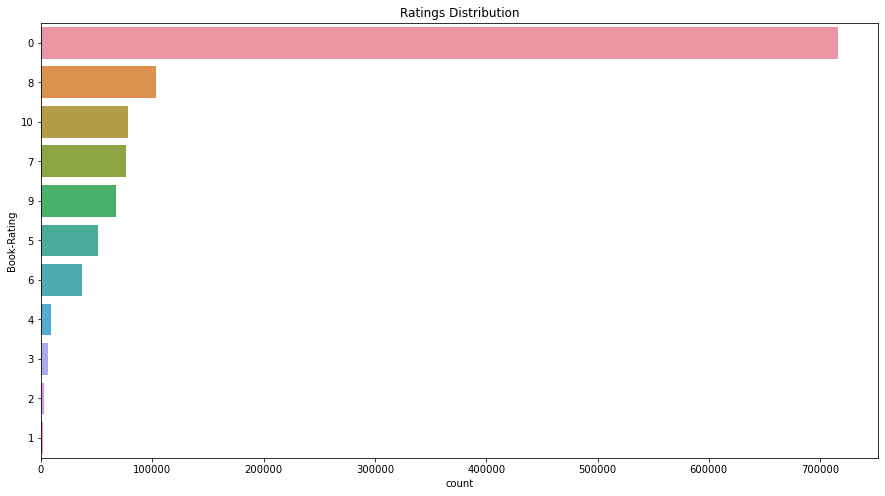

In [80]:
#checking the distribution of ratings
count_plot('Book-Rating', ratings, 'Ratings Distribution')

The ratings are unevenly distributed since majority of the ratings are 0. The ratings are either explicit, expressed on a scale of 1-10 with higher values denoting higher appreciation, or implicit, expressed by 0. Hence the need to segragate implicit and explict ratings datasets

In [81]:
#segregating implicit and explict ratings datasets
ratings_explicit = ratings_new[ratings['Book-Rating'] != 0]
ratings_implicit = ratings_new[ratings['Book-Rating'] == 0]

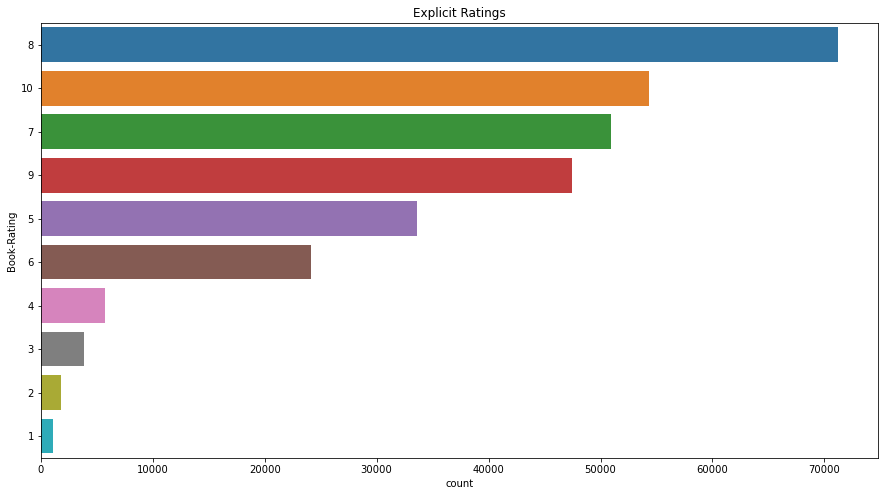

In [82]:
#plotting the explicit ratings
count_plot('Book-Rating', ratings_explicit, 'Explicit Ratings')

It can be observed that higher ratings are most common amongst users and rating 8 has been rated the highest number of times.

In [83]:
#finding the top 5 books that are rated most
rating_count = pd.DataFrame(ratings_explicit.groupby('ISBN')['Book-Rating'].count())
rating_count.sort_values('Book-Rating', ascending=False).head()

,Book-Rating
ISBN,
0316666343,707
0971880107,581
0385504209,487
0312195516,383
059035342X,313


In [84]:
#discovering which book is displayed by the above ISBN numbers
most_rated_books = pd.DataFrame(['0316666343', '0971880107', '0385504209', '0312195516', '0060928336'], index=np.arange(5), columns = ['ISBN'])
most_rated_books_summary = pd.merge(most_rated_books, published2, on='ISBN')
most_rated_books_summary

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,description,page_count,categories,maturity_rating,language,join_isbn_10
0,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002.0,"Little, Brown","The spirit of fourteen-year-old Susie Salmon describes her murder, her surprise at her new home in heaven, and her witness to her family's grief, efforts to find the killer, and attempts to come to terms with what has happened. A first novel. Reprint. 50,000 first printing.",372,['Fiction'],NOT_MATURE,en,0316666343
1,0971880107,Wild Animus,Rich Shapero,2004.0,Too Far,"Wild animus is a search for the primordial, a test of human foundations and a journey to the breaking point.",328,['Fiction'],NOT_MATURE,en,0971880107
2,0385504209,The Da Vinci Code,Dan Brown,2003.0,Doubleday,"Harvard symbologist Robert Langdon and French cryptologist Sophie Neveu work to solve the murder of an elderly curator of the Louvre, a case which leads to clues hidden in the works of Da Vinci and a centuries-old secret society.",472,['Fiction'],NOT_MATURE,en,0385504209
3,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998.0,Picador USA,"Her name is Dinah. In the Bible, her life is only hinted at in a brief and violent detour within the more familiar chapters of the Book of Genesis that are about her father, Jacob, and his dozen sons. Told in Dinah's voice, this novel reveals the traditions and turmoils of ancient womanhood--the world of the red tent. It begins with the story of her mothers--Leah, Rachel, Zilpah, and Bilhah--the four wives of Jacob. They love Dinah and give her gifts that sustain her through a hard-working youth, a calling to midwifery, and a new home in a foreign land. Dinah's story reaches out from a remarkable period of early history and creates an intimate connection with the past. Deeply affecting, The Red Tent combines rich storytelling with a valuable achievement in modern fiction: a new view of biblical women's society.",336,['Fiction'],NOT_MATURE,en,0312195516


Majority of the books that had a high rating are mainly of category fiction and are all novels. This shows that novels of type fiction are mainly preferred by users

In [85]:
# Create column Rating average 
ratings_explicit['Avg_Rating']=ratings_explicit.groupby('ISBN')['Book-Rating'].transform('mean')
# Create column Rating sum
ratings_explicit['Total_No_Of_Users_Rated']=ratings_explicit.groupby('ISBN')['Book-Rating'].transform('count')

In [86]:
ratings_explicit.head()

,User-ID,ISBN,Book-Rating,Avg_Rating,Total_No_Of_Users_Rated
3,276729,052165615X,3,3.000000,1
4,276729,0521795028,6,6.000000,1
16,276747,0060517794,9,8.000000,30
19,276747,0671537458,9,7.176471,17
20,276747,0679776818,8,7.476190,21


In [87]:
#merging explicit ratings to the users dataset and published2 dataset
Final_Dataset=users.copy()
Final_Dataset=pd.merge(Final_Dataset,ratings_explicit,on='User-ID')
Final_Dataset=pd.merge(Final_Dataset,published2,on='ISBN')

In [88]:
Final_Dataset.head()

,User-ID,Age,City,State,Country,ISBN,Book-Rating,Avg_Rating,Total_No_Of_Users_Rated,Book-Title,Book-Author,Year-Of-Publication,Publisher,description,page_count,categories,maturity_rating,language,join_isbn_10
0,8,32,timmins,ontario,canada,074322678X,5,5.0,1,Where You'll Find Me: And Other Stories,Ann Beattie,2002.0,Scribner,"Now back in print, Ann Beattie's finest short story collection, reissued to accompany the publication of her latest novel, ""The Doctor's House."" Most of the characters in ""Where You'll Find Me"" grew up in the 1960s and 1970s, are in their twenties and thirties and embody a curious, yet familiar, fusion of hope and despair. In finely crafted narratives, Beattie writes of women nursing broken hearts, men looking for love, and married couples struggling to stay together.",207,['Fiction'],NOT_MATURE,en,074322678X
1,8,32,timmins,ontario,canada,0887841740,5,5.0,1,The Middle Stories,Sheila Heti,2004.0,House of Anansi Press,"Part Dorothy Parker, part Jose Saramago, with shades of George Orwell, Sheila Heti has arrived on Canada's literary scene a fully formed artist. Balancing wisdom and innocence, joy and foreboding, each story in The Middle Stories leads us to surprising places. A frog doles out sage advice to a plumber infatuated with a princess, a boy falls hopelessly in love with a monkey, and a man with a hat keeps apocalyptic thoughts at bay by resolving to follow a plan that he admits he won't stick to. Globe and Mail critic Russell Smith has described Heti's stories as cryptic fairy tales without morals at the end, but really the morals are in the quality of the telling and in the details disclosed along the way. Look where you weren't going to look, think what you wouldn't have thought, Heti seems to say, and meaning itself gains more meaning and more dimensions. Heti's stories are not what you expect, but why did you expect that anyway?""",144,['Fiction'],NOT_MATURE,en,0887841740
2,8,32,timmins,ontario,canada,1575663937,6,6.0,1,More Cunning Than Man: A Social History of Rats and Man,Robert Hendrickson,1999.0,Kensington Publishing Corp.,"This eye-opening, well-researched examination of mankind's oldest competitor is filled with weirdly fascinating information about the history of the rat and the way it consistently outsmarts man. Illustrations.",300,['Nature'],NOT_MATURE,en,1575663937
3,8,32,timmins,ontario,canada,1881320189,7,7.0,2,Goodbye to the Buttermilk Sky,Julia Oliver,1994.0,River City Pub,"A beautifully narrated novel of time and place, ""Goodbye to the Buttermilk Sky"" re-creates a southern summer when the depression and the boll weevil turned hopes to dust. With the extraordinary talent to make the reader see the Ball canning jars on the kitchen table, hear the clicks on the party line, and feel the bittersweet moments of 20-year-old Callie Tatum's first experiences with adult desire, Oliver portrays a young wife's increasingly dangerous infidelity with cinematic precision and palpable suspense.",191,['Fiction'],NOT_MATURE,en,1881320189
4,226745,38,humble,other,other,1881320189,7,7.0,2,Goodbye to the Buttermilk Sky,Julia Oliver,1994.0,River City Pub,"A beautifully narrated novel of time and place, ""Goodbye to the Buttermilk Sky"" re-creates a southern summer when the depression and the boll weevil turned hopes to dust. With the extraordinary talent to make the reader see the Ball canning jars on the kitchen table, hear the clicks on the party line, and feel the bittersweet moments of 20-year-old Callie Tatum's first experiences with adult desire, Oliver portrays a young wife's increasingly dangerous infidelity with cinematic precision and palpable suspense.",191,['Fiction'],NOT_MATURE,en,1881320189


In [89]:
fd = DescribeData(Final_Dataset)

In [90]:
print(fd.missing)

There are a total of 0 missing values in the DataFrame.

User-ID                    0
Age                        0
City                       0
State                      0
Country                    0
ISBN                       0
Book-Rating                0
Avg_Rating                 0
Total_No_Of_Users_Rated    0
Book-Title                 0
Book-Author                0
Year-Of-Publication        0
Publisher                  0
description                0
page_count                 0
categories                 0
maturity_rating            0
language                   0
join_isbn_10               0
dtype: int64


### Exploratory Data Analysis

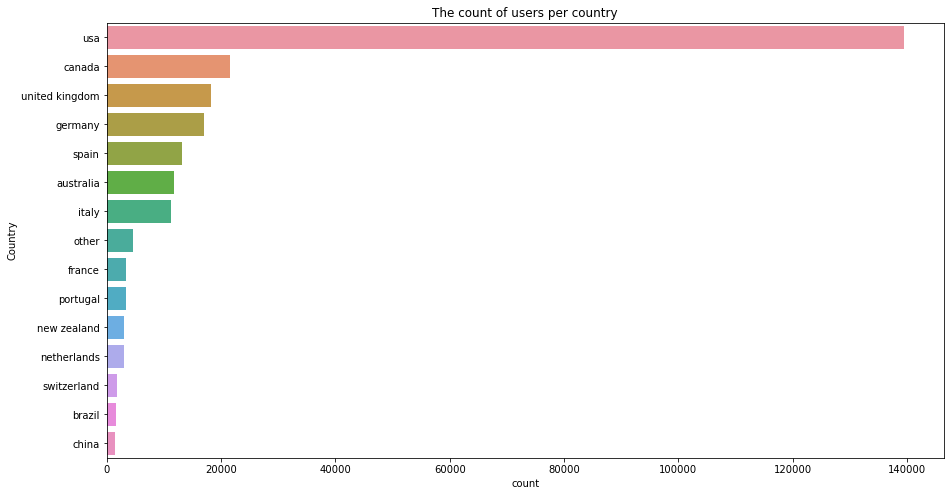

In [92]:
count_plot('Country', users, 'The count of users per country')

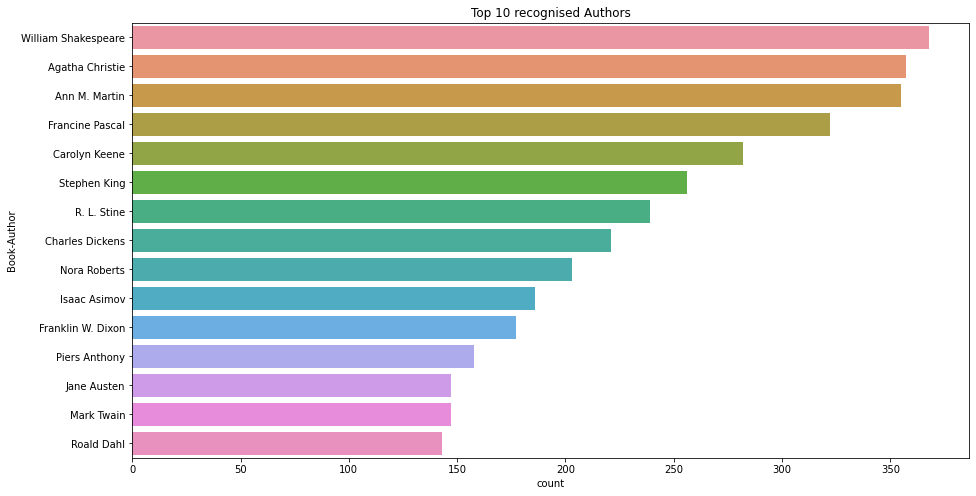

In [93]:
count_plot('Book-Author', published2, 'Top 10 recognised Authors')

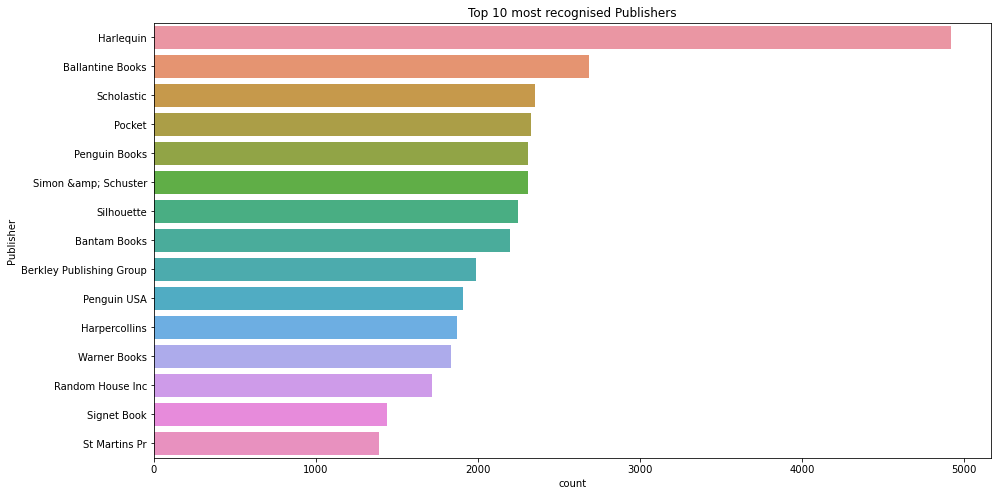

In [94]:
count_plot('Publisher', published2, 'Top 10 most recognised Publishers')